In [1]:
"""Example showing different sampling strategies"""

# Copyright (c) 2025 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__deprecated__ = False

# Sampling strategies

In this example, we show different strategies for sampling in `soogo`. The sampling strategies are used within optimization routines and acquisition functions in `soogo`.

- To enable visualization, we sample in two-dimensional spaces.
- The input space may have continuous and/or discrete variables. The examples below cover both cases.

In [2]:
from soogo.sampling import (
    NormalSampler,
    Sampler,
    SamplingStrategy,
    Mitchel91Sampler,
)
import numpy as np


def gen_int_bins(x):
    xmax = np.max(np.abs(x))
    n = int(xmax) + 2
    return [-0.5 + i for i in range(n)]


def gen_bins(x, binwidth: float):
    xmax = np.max(np.abs(x))
    n = int(round(xmax / binwidth)) + 1
    return [i * binwidth for i in range(n)]


def scatter_hist(x, y, ax, current_sample=None):
    """From: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html"""
    # the scatter plot:
    ax.scatter(x, y)
    if current_sample is not None:
        ax.scatter(current_sample[:, 0], current_sample[:, 1], marker="x")


def plot_sample_2d(sample, bounds, current_sample=None, iindex=()):
    """Adapted from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html"""
    import matplotlib.pyplot as plt

    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout="constrained")

    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()

    # The main axes' aspect can be fixed.
    ax.set(aspect=1)

    # Draw the scatter plot.
    scatter_hist(sample[:, 0], sample[:, 1], ax, current_sample)

    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    if current_sample is not None:
        hsample = np.vstack((sample,current_sample))
    else:
        hsample = sample
    if 0 not in iindex:
        xbins = gen_bins(hsample[:, 0], 0.05)
        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
        ax_histx.hist(hsample[:, 0], bins=xbins)
        ax_histx.tick_params(axis="x", labelbottom=False)  # no labels
    if 1 not in iindex:
        ybins = gen_bins(hsample[:, 1], 0.05)
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
        ax_histy.hist(hsample[:, 1], bins=ybins, orientation="horizontal")
        ax_histy.tick_params(axis="y", labelleft=False)  # no labels

    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])
    plt.show()

    for i in range(2):
        if i in iindex:
            bins = gen_int_bins(hsample[:, i])
            plt.hist(hsample[:, i], bins=bins)
            plt.xticks(list(range(bounds[i][0],bounds[i][1]+1)))
            # plt.tick_params(axis="x", labelbottom=False) # no labels
            plt.show()

## Continuous variables

Let us start by generating samples for continuous variables in the [0,1]x[0,1] domain.

In [3]:
# Define number of points to be sampled and the domain
m = 1000
dim = 2
bounds = [(0, 1)] * dim
lb = np.array([b[0] for b in bounds])
ub = np.array([b[1] for b in bounds])

### Uniform distribution

Sampling 1000 points using a random uniform distribution


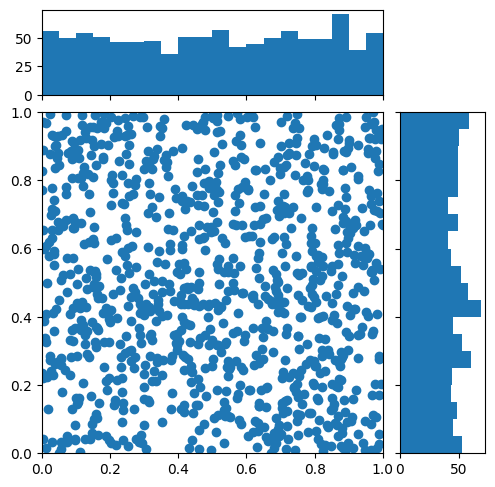

In [4]:
print("Sampling", m, "points using a random uniform distribution")
sample = Sampler(m).get_uniform_sample(bounds)
plot_sample_2d(sample, bounds)

### Symmetric Latin Hypercube design

This sampling strategy is useful whenever one wants to cover each of the coordinate directions in the space with equally spaced points. Notice that, as expected, the distributions on both axes display a constant shape.

Sampling 1000 points using SLHD


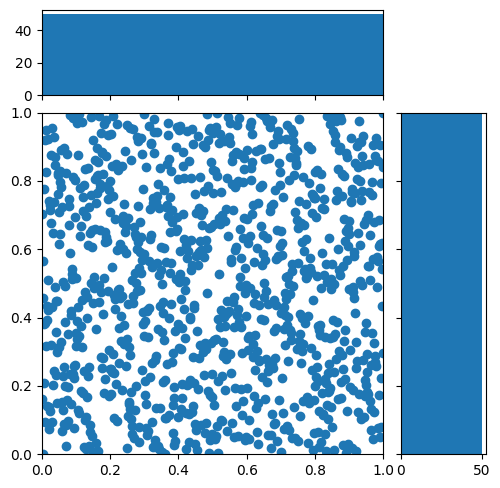

In [5]:
print("Sampling", m, "points using SLHD")
sample = Sampler(m).get_slhd_sample(bounds)
plot_sample_2d(sample, bounds)

### Normal distribution

The normal distribution is a perturbation of a point `mu` inside the domain using a standard deviation of `sigma`. Since the domain is bounded, the implementation of this function uses a truncated normal distribution that makes sure sampled points remain inside the domain, and preserves `mu` and `sigma`. In this example, we choose `sigma = 0.1` to perturb two locations: `mu = (0.5, 0.5)` and `mu = (0.1, 0.3)`.

Sampling 1000 points using a normal distribution with sigma 0.1 and mu [0.5 0.5]


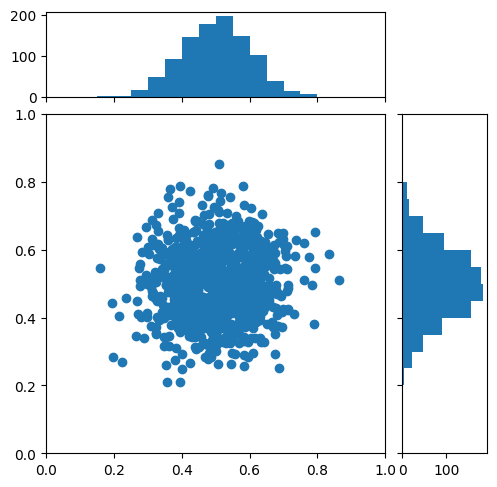

Sampling 1000 points using a normal distribution with sigma 0.1 and mu (0.1, 0.3)


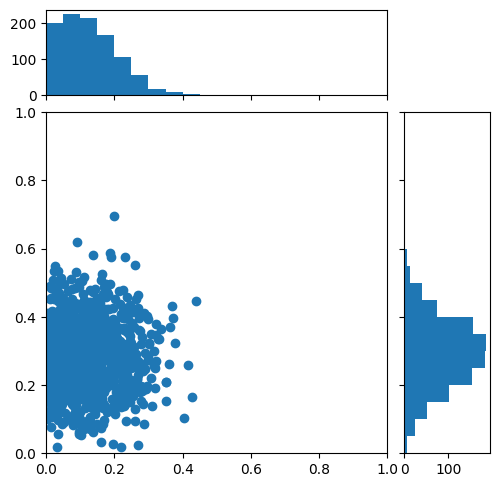

In [6]:
sigma = 0.1
mu = lb + (ub - lb) / 2
print(
    "Sampling",
    m,
    "points using a normal distribution with sigma",
    sigma,
    "and mu",
    mu,
)
sample = NormalSampler(m, sigma).get_normal_sample(bounds, mu=mu)
plot_sample_2d(sample, bounds)

sigma = 0.1
mu = (0.1, 0.3)
print(
    "Sampling",
    m,
    "points using a normal distribution with sigma",
    sigma,
    "and mu",
    mu,
)
sample = NormalSampler(m, sigma).get_normal_sample(bounds, mu=mu)
plot_sample_2d(sample, bounds)

### Dynamically Dimensioned Search (DDS)

Similarly to the normal distribution, the DDS algorithm perturbs of a point `mu` inside the domain using a standard deviation of `sigma`. Te DDS, though, samples from a uniform distribution to decide if a coordinate should be perturbed in a given sampled point. Thus, the final distributions per coordinate will show a lower deviation from the average. In this example, we also choose `sigma = 0.1` to perturb two locations: `mu = (0.5, 0.5)` and `mu = (0.1, 0.3)`. The perturbation occurs with probability 80%.

Sampling 1000 points using a DDS distribution with sigma 0.1 mu [0.5 0.5] and perturbation probability 0.8


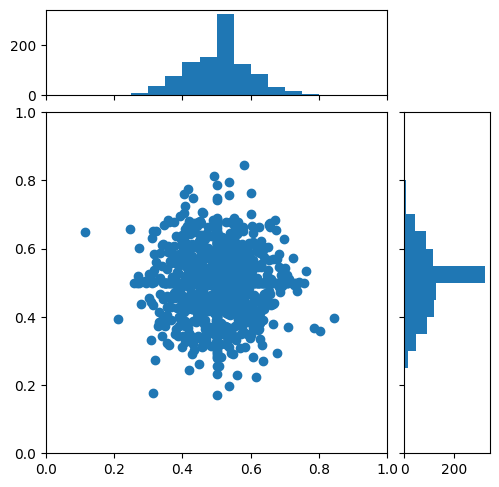

Sampling 1000 points using a DDS distribution with sigma 0.1 mu (0.1, 0.3) and perturbation probability 0.8


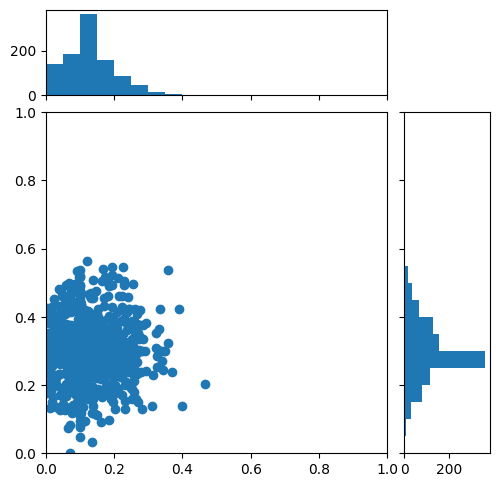

In [7]:
sigma = 0.1
mu = lb + (ub - lb) / 2
probability = 0.8
print(
    "Sampling",
    m,
    "points using a DDS distribution with sigma",
    sigma,
    "mu",
    mu,
    "and perturbation probability",
    probability,
)
sample = NormalSampler(m, sigma).get_dds_sample(
    bounds, mu=mu, probability=probability
)
plot_sample_2d(sample, bounds)

sigma = 0.1
mu = (0.1, 0.3)
probability = 0.8
print(
    "Sampling",
    m,
    "points using a DDS distribution with sigma",
    sigma,
    "mu",
    mu,
    "and perturbation probability",
    probability,
)
sample = NormalSampler(m, sigma).get_dds_sample(
    bounds, mu=mu, probability=probability
)
plot_sample_2d(sample, bounds)

### Mitchel (1991) sampler

This strategy is used to sample points in areas that weren't targeted before. This sampler then fill gaps in the search space.

Sampling 1000 points using the strategy from Mitchel (1991) with maxCand= 10000 and scale=2


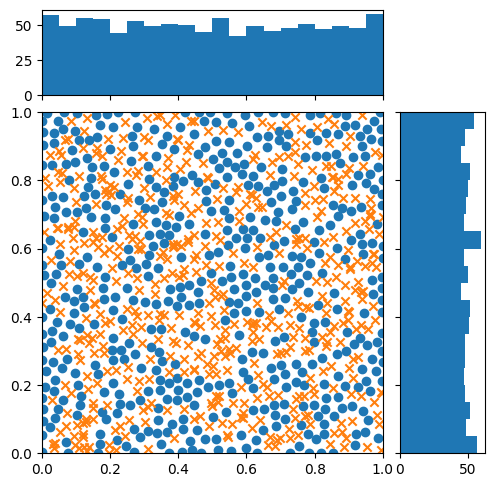

In [8]:
print(
    "Sampling",
    m,
    "points using the strategy from Mitchel (1991) with maxCand=",
    10*m,
    "and scale=2"
)
sampler = Mitchel91Sampler(m//2, maxCand=10*m, scale=2)
current = sampler.get_uniform_sample(bounds)
sample = sampler.get_sample(bounds, current_sample=current)
plot_sample_2d(sample, bounds, current_sample=current)

## Mixed-integer sampling

The code that follows uses the same sampling strategies presented above on the space {0,1,...,10}x[0,1]. We only sample 100 points per method instead of 1000, to improve visualization. Notice the distinctions between the distributions for the continuous and mixed-integer cases.

In [9]:
# Now, let's look at the mixed-integer sampling

m = 100
dim = 2
bounds = [(0, 10), (0,1)]
iindex = (0,)
lb = np.array([b[0] for b in bounds])
ub = np.array([b[1] for b in bounds])

Mixed-integer sampling 100 points using a random uniform distribution


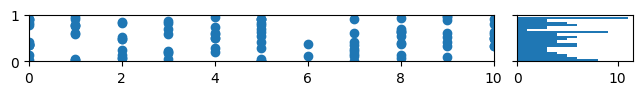

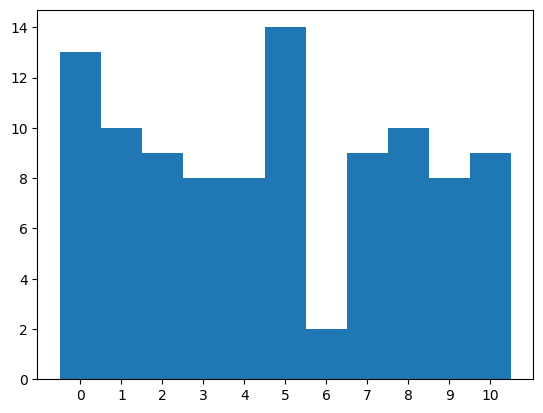

In [10]:
print("Mixed-integer sampling", m, "points using a random uniform distribution")
sample = Sampler(m).get_uniform_sample(bounds, iindex=iindex)
plot_sample_2d(sample, bounds, iindex=iindex)

The SLHD strategy can be adapted to a discrete variable. Mind that not all values will appear the same number of times if the number of samples is not a multiple of the cardinality of the discrete space.

Mixed-integer sampling 100 points using SLHD


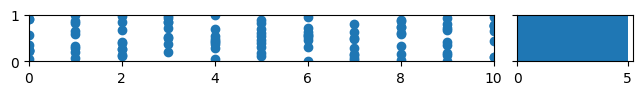

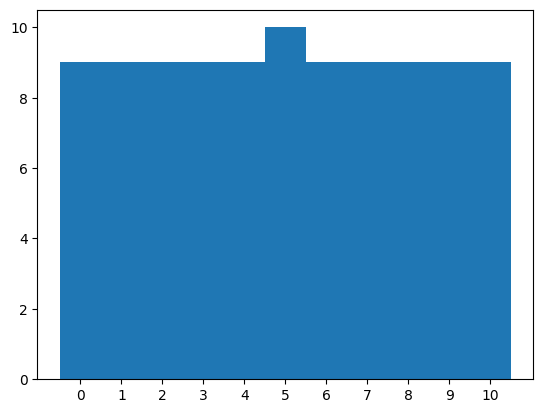

In [11]:
print("Mixed-integer sampling", m, "points using SLHD")
sample = Sampler(m).get_slhd_sample(bounds, iindex=iindex)
plot_sample_2d(sample, bounds, iindex=iindex)

The normal distribution can be emulated for discrete variables, by sampling on the respective continuous counterpart and rounding to the closest integer. We use points `mu=(5,0.5)` and `mu=(1,0.3)` in the mixed-integer scenario.

Mixed-integer sampling 100 points using a normal distribution with sigma 0.1 and mu [5.  0.5]


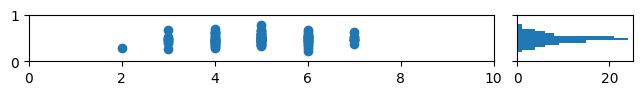

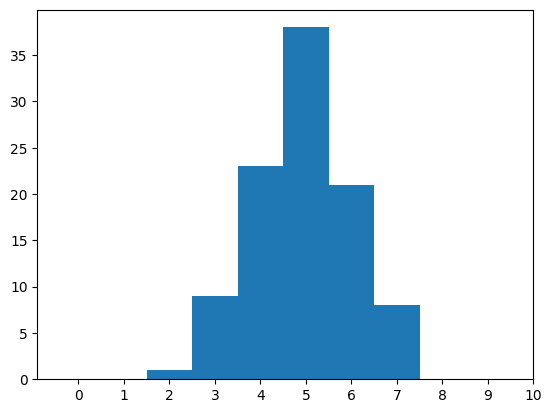

Mixed-integer sampling 100 points using a normal distribution with sigma 0.1 and mu (1, 0.3)


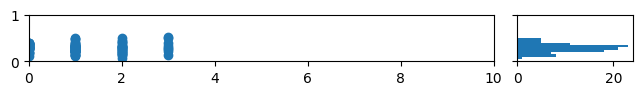

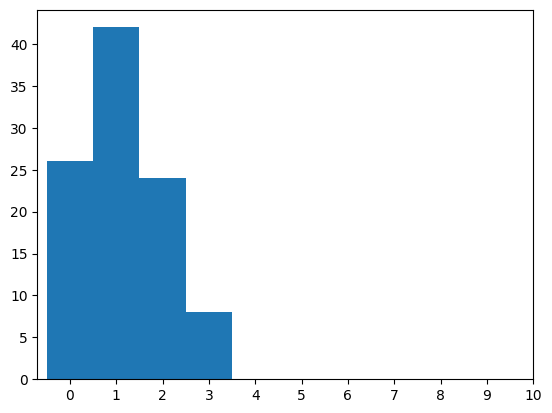

In [12]:
sigma = 0.1
mu = lb + (ub - lb) / 2
print(
    "Mixed-integer sampling",
    m,
    "points using a normal distribution with sigma",
    sigma,
    "and mu",
    mu,
)
sample = NormalSampler(m, sigma).get_normal_sample(
    bounds, mu=mu, iindex=iindex
)
plot_sample_2d(sample, bounds, iindex=iindex)

sigma = 0.1
mu = (1, 0.3)
print(
    "Mixed-integer sampling",
    m,
    "points using a normal distribution with sigma",
    sigma,
    "and mu",
    mu,
)
sample = NormalSampler(m, sigma).get_normal_sample(
    bounds, mu=mu, iindex=iindex
)
plot_sample_2d(sample, bounds, iindex=iindex)

The DDS has a specific implementation for integer variables, where it establishes that the perturbation should be at least by 1 unit in the case the axis is chosen to be perturbed. That peculiarity makes the average value less probable, which has an impact in the shape of the probability distribution function.

Mixed-integer sampling 100 points using a DDS distribution with sigma 0.1 mu [5.  0.5] and perturbation probability 0.8


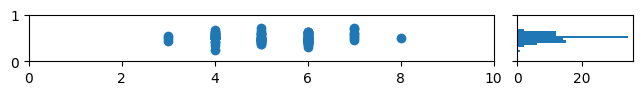

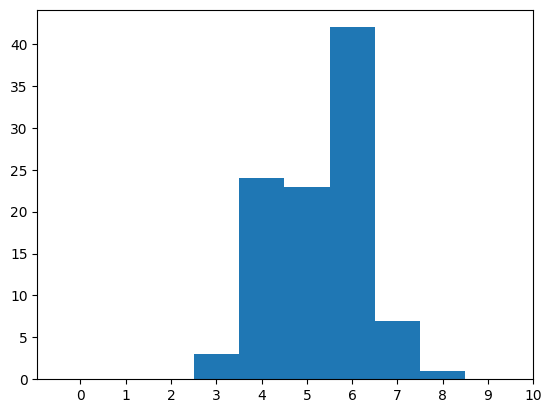

Mixed-integer sampling 100 points using a DDS distribution with sigma 0.1 mu (1, 0.3) and perturbation probability 0.8


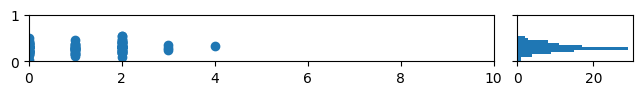

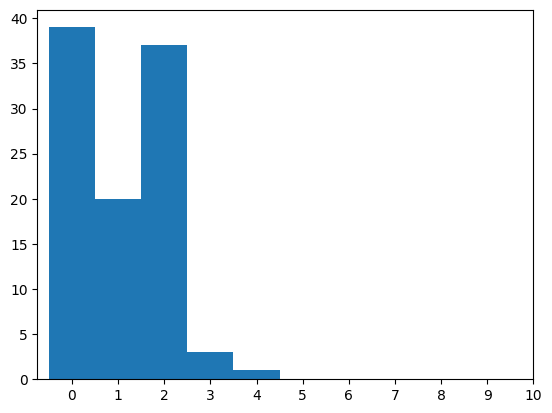

In [13]:
sigma = 0.1
mu = lb + (ub - lb) / 2
probability = 0.8
print(
    "Mixed-integer sampling",
    m,
    "points using a DDS distribution with sigma",
    sigma,
    "mu",
    mu,
    "and perturbation probability",
    probability,
)
sample = NormalSampler(m, sigma).get_dds_sample(
    bounds, mu=mu, probability=probability, iindex=iindex
)
plot_sample_2d(sample, bounds, iindex=iindex)

sigma = 0.1
mu = (1,0.3)
probability = 0.8
print(
    "Mixed-integer sampling",
    m,
    "points using a DDS distribution with sigma",
    sigma,
    "mu",
    mu,
    "and perturbation probability",
    probability,
)
sample = NormalSampler(m, sigma).get_dds_sample(
    bounds, mu=mu, probability=probability, iindex=iindex
)
plot_sample_2d(sample, bounds, iindex=iindex)

Mixed-integer sampling 100 points using the strategy from Mitchel (1991) with maxCand= 1000 and scale=2


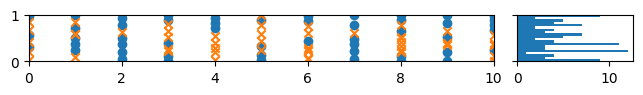

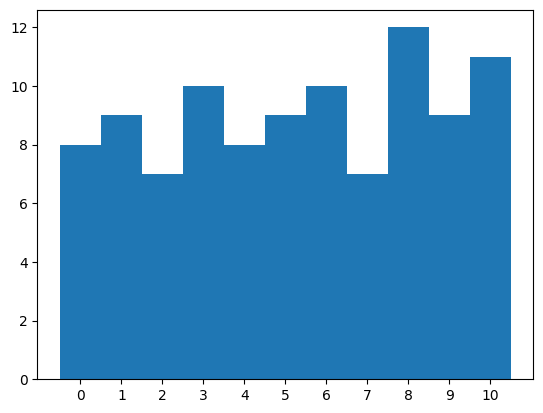

In [14]:
print(
    "Mixed-integer sampling",
    m,
    "points using the strategy from Mitchel (1991) with maxCand=",
    10*m,
    "and scale=2"
)
sampler = Mitchel91Sampler(m//2, maxCand=10*m, scale=2)
current = sampler.get_uniform_sample(bounds, iindex=iindex)
sample = sampler.get_sample(bounds, current_sample=current, iindex=iindex)
plot_sample_2d(sample, bounds, current_sample=current, iindex=iindex)